### Questions to Answer:
1. What is the best time so sell?

2. What are the popular items?

3. What items are usually bought together? (Association Mining Rule) 

4. What is the trend?

### Dataset was obtained from Kaggle: https://www.kaggle.com/mittalvasu95/the-bread-basket/notebooks

# Data Auditing

In [1]:
#pip install apriori
#pip install mlxtend
#pip install seaborn

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori, association_rules


Bad key "text.kerning_factor" on line 4 in
C:\Users\Kvis\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [3]:
# read csv 
df = pd.read_csv('bread basket.csv')

In [4]:
# first look
df.head()

,Transaction,Item,date_time,period_day,weekday_weekend
0,1,Bread,30-10-2016 09:58,morning,weekend
1,2,Scandinavian,30-10-2016 10:05,morning,weekend
2,2,Scandinavian,30-10-2016 10:05,morning,weekend
3,3,Hot chocolate,30-10-2016 10:07,morning,weekend
4,3,Jam,30-10-2016 10:07,morning,weekend


In [5]:
# check for null values
print(df.shape)
print('----------------------------')
print('There are no NULL values:')
print(df.isna().sum())
print('----------------------------')
print(df.info())

(20507, 5)
----------------------------
There are no NULL values:
Transaction        0
Item               0
date_time          0
period_day         0
weekday_weekend    0
dtype: int64
----------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20507 entries, 0 to 20506
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Transaction      20507 non-null  int64 
 1   Item             20507 non-null  object
 2   date_time        20507 non-null  object
 3   period_day       20507 non-null  object
 4   weekday_weekend  20507 non-null  object
dtypes: int64(1), object(4)
memory usage: 801.2+ KB
None


In [6]:
# look at figures from categorical data
df.describe(include = ['O'])

,Item,date_time,period_day,weekday_weekend
count,20507,20507,20507,20507
unique,94,9182,4,2
top,Coffee,05-02-2017 11:58,afternoon,weekday
freq,5471,12,11569,12807


In [7]:
df.Item.unique()

array(['Bread', 'Scandinavian', 'Hot chocolate', 'Jam', 'Cookies',
       'Muffin', 'Coffee', 'Pastry', 'Medialuna', 'Tea', 'Tartine',
       'Basket', 'Mineral water', 'Farm House', 'Fudge', 'Juice',
       "Ella's Kitchen Pouches", 'Victorian Sponge', 'Frittata',
       'Hearty & Seasonal', 'Soup', 'Pick and Mix Bowls', 'Smoothies',
       'Cake', 'Mighty Protein', 'Chicken sand', 'Coke',
       'My-5 Fruit Shoot', 'Focaccia', 'Sandwich', 'Alfajores', 'Eggs',
       'Brownie', 'Dulce de Leche', 'Honey', 'The BART', 'Granola',
       'Fairy Doors', 'Empanadas', 'Keeping It Local', 'Art Tray',
       'Bowl Nic Pitt', 'Bread Pudding', 'Adjustment', 'Truffles',
       'Chimichurri Oil', 'Bacon', 'Spread', 'Kids biscuit', 'Siblings',
       'Caramel bites', 'Jammie Dodgers', 'Tiffin', 'Olum & polenta',
       'Polenta', 'The Nomad', 'Hack the stack', 'Bakewell',
       'Lemon and coconut', 'Toast', 'Scone', 'Crepes', 'Vegan mincepie',
       'Bare Popcorn', 'Muesli', 'Crisps', 'Pintxos', 

# Preparing data for analysis

In [8]:
df['Quantity'] = 1 #assign quantity bought for each row
df1 = df.copy() # create a copy of original data
df1 = df.groupby(['Transaction','Item','date_time','period_day','weekday_weekend']).sum()

#pivot Items to columns to run Apriori Algorithm later. The new dataframe has 98 columns now.
df1 = df1.pivot_table('Quantity',['Transaction','date_time','period_day','weekday_weekend'],'Item').reset_index().rename_axis(None, axis=1).fillna(0)
df1.head(2)

,Transaction,date_time,period_day,weekday_weekend,Adjustment,Afternoon with the baker,Alfajores,Argentina Night,Art Tray,Bacon,...,The BART,The Nomad,Tiffin,Toast,Truffles,Tshirt,Valentine's card,Vegan Feast,Vegan mincepie,Victorian Sponge
0,1,30-10-2016 09:58,morning,weekend,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,30-10-2016 10:05,morning,weekend,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# looks like customers will only buy maximum 3 items at once
bought = df1['date_time'].value_counts()
bought = pd.DataFrame(bought).reset_index().rename(columns = {'index': 'datetime', 'date_time':'number'})

# items bought in 1 transaction
# it looks like only less than 4% of people will buy more than 1 item
print("3 items:", round(len(bought[bought['number'] == 3])/len(bought['number'])*100,2),'%',sep='')
print("2 items:", round(len(bought[bought['number'] == 2])/len(bought['number'])*100,2),'%',sep='')
print("1 items:", round(len(bought[bought['number'] == 1])/len(bought['number'])*100,2),'%',sep='')

3 items:0.04%
2 items:2.99%
1 items:96.96%


In [10]:
# split the date_time into Date, Time, Month, Year and Date for easier analysis later
df1['date_time'] = pd.to_datetime(df['date_time'])
df1['Date'] = df1['date_time'].dt.strftime('%d-%m-%Y')
df1['Time'] = df1['date_time'].dt.strftime('%H:%M:%S')
df1['Month'] = df1['date_time'].dt.strftime('%b')
df1['Year'] = df1['date_time'].dt.strftime('%Y')
df1['Day'] = df1['date_time'].dt.strftime('%a')

# drop date_time column as we don't need it anymore
#df1 = df1.drop(columns='date_time') 

# move the date time columns to the front so that it is easier to visualise
col = df1.pop('Date')
df1.insert(1, col.name, col)
col = df1.pop('Time')
df1.insert(2, col.name, col)
col = df1.pop('Day')
df1.insert(3, col.name, col)
col = df1.pop('Month')
df1.insert(4, col.name, col)
col = df1.pop('Year')
df1.insert(5, col.name, col)
df1.head(2)

,Transaction,Date,Time,Day,Month,Year,date_time,period_day,weekday_weekend,Adjustment,...,The BART,The Nomad,Tiffin,Toast,Truffles,Tshirt,Valentine's card,Vegan Feast,Vegan mincepie,Victorian Sponge
0,1,30-10-2016,09:58:00,Sun,Oct,2016,2016-10-30 09:58:00,morning,weekend,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,30-10-2016,10:05:00,Sun,Oct,2016,2016-10-30 10:05:00,morning,weekend,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### The number of transactions by day: Friday, Saturday and Monday are the busiest.

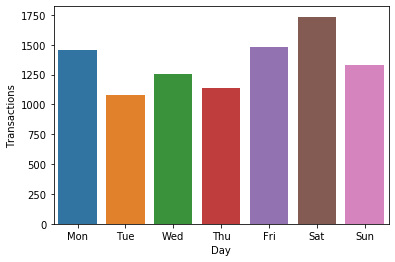

In [11]:
df1['Day'] = pd.Categorical(df1['Day'], categories= ['Mon','Tue','Wed','Thu','Fri','Sat', 'Sun'], ordered=True)
day = df1['Day'].value_counts()
day = day.sort_index().reset_index().rename(columns={'index':'Day','Day':'Transactions'})
ax = sns.barplot(x="Day", y="Transactions", data=day)

### The number of transactions by month: November and December are the busiest.

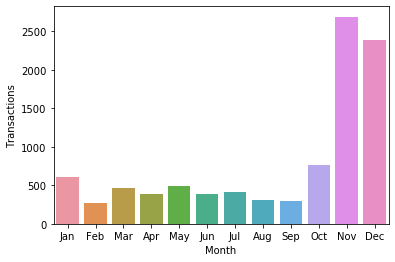

In [12]:
df1['Month'] = pd.Categorical(df1['Month'], categories= ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], ordered=True)
month = df1['Month'].value_counts()
month = month.sort_index().reset_index().rename(columns={'index':'Month','Month':'Transactions'})
ax = sns.barplot(x="Month", y="Transactions", data=month)

### The number of transactions by period of day: Morning and Afternoon are the busiest.

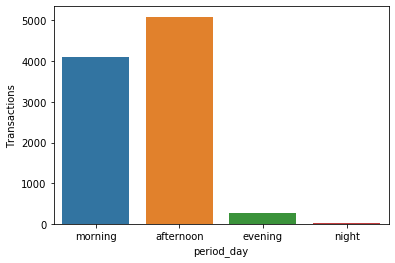

In [13]:
df1['period_day'] = pd.Categorical(df1['period_day'], categories= ['morning','afternoon','evening','night'], ordered=True)
period_day = df1['period_day'].value_counts()
period_day = period_day.sort_index().reset_index().rename(columns={'index':'period_day','period_day':'Transactions'})
ax = sns.barplot(x="period_day", y="Transactions", data=period_day)

### The number of transactions by year: Sales in 2017 seems to have plunged compared to 2016.

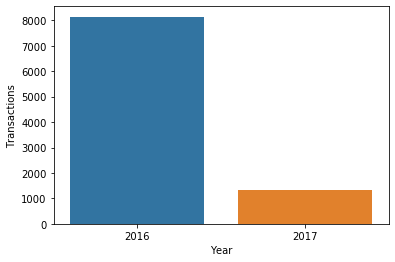

In [14]:
year = pd.DataFrame(df1.Year.value_counts())
year = year.reset_index().rename(columns={'index':'Year','Year':'Transactions'})
ax = sns.barplot(x="Year", y="Transactions", data=year)

### % change compared to previous year:

In [15]:
# select data by year to for a new dataframe
df_2016 = df1[df1['Year'] == '2016']
df_2017 = df1[df1['Year'] == '2017']

# extract number of transactions by month
monthly_sales_2016 = pd.DataFrame(df_2016['Month'].value_counts().reset_index().rename(columns = {'index': 'Month', 'Month':'2016'}))
monthly_sales_2017 = pd.DataFrame(df_2017['Month'].value_counts()).reset_index().rename(columns = {'index': 'Month', 'Month':'2017'})

# merge sales data for both years
monthly_sales = pd.merge(monthly_sales_2016,monthly_sales_2017)

# sort by month
monthly_sales['Month'] = pd.Categorical(monthly_sales['Month'], categories= ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], ordered=True)
monthly_sales.sort_values(inplace=True, by='Month')
monthly_sales = monthly_sales.reset_index().drop('index', axis=1)

# % change compared to previous year
print('% change compared to previous year:')
monthly_sales['% Change'] = round(((monthly_sales['2017']-monthly_sales['2016'])/monthly_sales['2016']*100),2).astype(str) + '%'
monthly_sales

% change compared to previous year:


,Month,2016,2017,% Change
0,Jan,233,368,57.94%
1,Feb,268,0,-100.0%
2,Mar,380,87,-77.11%
3,Apr,308,76,-75.32%
4,May,392,95,-75.77%
5,Jun,307,84,-72.64%
6,Jul,229,188,-17.9%
7,Aug,212,103,-51.42%
8,Sep,218,82,-62.39%
9,Oct,688,71,-89.68%


### Compare month-by-month for 2016 & 2017

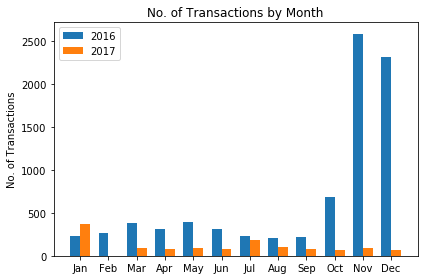

In [16]:
# plot grouped bar plot to compare month-by-month for 2016 & 2017
labels = monthly_sales['Month']
sales_2016 = monthly_sales['2016']
sales_2017 = monthly_sales['2017']

x = np.arange(len(monthly_sales['Month']))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, sales_2016, width, label='2016')
rects2 = ax.bar(x + width/2, sales_2017, width, label='2017')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('No. of Transactions')
ax.set_title('No. of Transactions by Month')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

df1['Date'] = pd.to_datetime(df1['Date'])
df1['Time'] = pd.to_datetime(df1['Time'])

### What are the popular items?

In [17]:
total_transactions = len(df1)
support = 0.02
min_items = total_transactions*support

itemset_1 = pd.DataFrame(df.Item.value_counts()).reset_index().rename(columns = {'index':'Item','Item':'Count'})
itemset_1 = itemset_1[itemset_1['Count'] >= min_items]
itemset_1

,Item,Count
0,Coffee,5471
1,Bread,3325
2,Tea,1435
3,Cake,1025
4,Pastry,856
5,Sandwich,771
6,Medialuna,616
7,Hot chocolate,590
8,Cookies,540
9,Brownie,379


### Visualise popular items on a barplot

[Text(0, 0, 'Coffee'),
 Text(0, 0, 'Bread'),
 Text(0, 0, 'Tea'),
 Text(0, 0, 'Cake'),
 Text(0, 0, 'Pastry'),
 Text(0, 0, 'Sandwich'),
 Text(0, 0, 'Medialuna'),
 Text(0, 0, 'Hot chocolate'),
 Text(0, 0, 'Cookies'),
 Text(0, 0, 'Brownie'),
 Text(0, 0, 'Farm House'),
 Text(0, 0, 'Muffin'),
 Text(0, 0, 'Alfajores'),
 Text(0, 0, 'Juice'),
 Text(0, 0, 'Soup'),
 Text(0, 0, 'Scone'),
 Text(0, 0, 'Toast'),
 Text(0, 0, 'Scandinavian'),
 Text(0, 0, 'Truffles')]

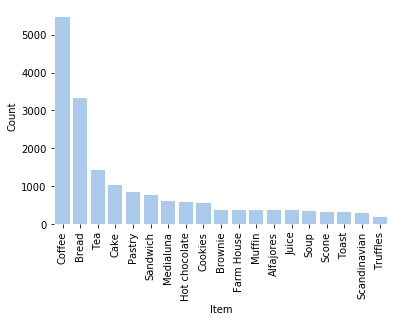

In [18]:
# Initialize the matplotlib figure
#f, ax = plt.subplots(figsize=(6, 15))

# Plot the total crashes
sns.set_color_codes("pastel")
t = sns.barplot(x="Item", y="Count", data=itemset_1,
            label="Item", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
#ax.set(xlim=(0, 24), ylabel="", xlabel="Popular Items Sold")
sns.despine(left=True, bottom=True)
t.set_xticklabels(itemset_1['Item'],rotation=90)

## Frequent Pattern Mining via Apriori Algorithm

#### Although there is only a small amount of customers that would buy more than 1 item. However, it is still worthwhile to find any Associations on multiple items bought to upsell. Another benefit is to possibly create a 'deal' say, Coffee + Scone at a cheaper price. This will encourage customers to buy multiple items instead of just 1 item only.


#### Apriori Algorithm reference: https://www.geeksforgeeks.org/implementing-apriori-algorithm-in-python/

In [19]:
def hot_encode(x): 
    if(x<= 0): 
        return 0
    if(x>= 1): 
        return 1

basket = df1.iloc[:,9:]
basket_encoded = basket.applymap(hot_encode)
basket_encoded.head(1)

,Adjustment,Afternoon with the baker,Alfajores,Argentina Night,Art Tray,Bacon,Baguette,Bakewell,Bare Popcorn,Basket,...,The BART,The Nomad,Tiffin,Toast,Truffles,Tshirt,Valentine's card,Vegan Feast,Vegan mincepie,Victorian Sponge
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
# Building the model 
frq_items = apriori(basket_encoded, min_support = 0.01, use_colnames = True) 
  
# Collecting the inferred rules in a dataframe 
rules = association_rules(frq_items, metric ="lift", min_threshold = 1) 
rules = rules.sort_values(['confidence', 'lift'], ascending =[True, True]) 
print(pd.DataFrame(rules))

         antecedents       consequents  antecedent support  \
29          (Coffee)  (Spanish Brunch)            0.478394   
27          (Coffee)           (Scone)            0.478394   
20          (Coffee)          (Muffin)            0.478394   
5           (Coffee)         (Brownie)            0.478394   
1           (Coffee)       (Alfajores)            0.478394   
17          (Coffee)           (Juice)            0.478394   
30          (Coffee)           (Toast)            0.478394   
13          (Coffee)         (Cookies)            0.478394   
15          (Coffee)   (Hot chocolate)            0.478394   
40             (Tea)    (Cake, Coffee)            0.142631   
19          (Coffee)       (Medialuna)            0.478394   
25          (Coffee)        (Sandwich)            0.478394   
3            (Bread)          (Pastry)            0.327205   
35            (Cake)   (Bread, Coffee)            0.103856   
41            (Cake)     (Tea, Coffee)            0.103856   
23      

### Drawing from the fact that only about 3% of customers buy more than 1 item, the association between items purchased are not expected to be high as shown in the lift, support and confidence figures. However, they are still worth noting for every opportunity to upsell to increase revenue.

# Visualisation on number of transactions over time

In [21]:
# prepare data for 2016
# sorting Month
monthly_sales_2016['Month'] = pd.Categorical(monthly_sales_2016['Month'], categories= ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], ordered=True)
monthly_sales_2016 = monthly_sales_2016.rename(columns={'2016':'Transactions'})
monthly_sales_2016.sort_values(inplace=True, by='Month')
monthly_sales_2016['Month'] = monthly_sales_2016['Month'].astype(str) + '_2016'

# prepare data for 2017
# sorting Month
monthly_sales_2017['Month'] = pd.Categorical(monthly_sales_2017['Month'], categories= ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], ordered=True)
monthly_sales_2017 = monthly_sales_2017.rename(columns={'2017':'Transactions'})
monthly_sales_2017.sort_values(inplace=True, by='Month')
monthly_sales_2017['Month'] = monthly_sales_2017['Month'].astype(str) + '_2017'

# merge both datasets
merged = monthly_sales_2016.append([monthly_sales_2017])
merged = merged.reset_index().drop(['index'], axis=1)
merged

,Month,Transactions
0,Jan_2016,233
1,Feb_2016,268
2,Mar_2016,380
3,Apr_2016,308
4,May_2016,392
5,Jun_2016,307
6,Jul_2016,229
7,Aug_2016,212
8,Sep_2016,218
9,Oct_2016,688


[Text(0, 0, 'Jan_2016'),
 Text(0, 0, 'Feb_2016'),
 Text(0, 0, 'Mar_2016'),
 Text(0, 0, 'Apr_2016'),
 Text(0, 0, 'May_2016'),
 Text(0, 0, 'Jun_2016'),
 Text(0, 0, 'Jul_2016'),
 Text(0, 0, 'Aug_2016'),
 Text(0, 0, 'Sep_2016'),
 Text(0, 0, 'Oct_2016'),
 Text(0, 0, 'Nov_2016'),
 Text(0, 0, 'Dec_2016'),
 Text(0, 0, 'Jan_2017'),
 Text(0, 0, 'Feb_2017'),
 Text(0, 0, 'Mar_2017'),
 Text(0, 0, 'Apr_2017'),
 Text(0, 0, 'May_2017'),
 Text(0, 0, 'Jun_2017'),
 Text(0, 0, 'Jul_2017'),
 Text(0, 0, 'Aug_2017'),
 Text(0, 0, 'Sep_2017'),
 Text(0, 0, 'Oct_2017'),
 Text(0, 0, 'Nov_2017'),
 Text(0, 0, 'Dec_2017')]

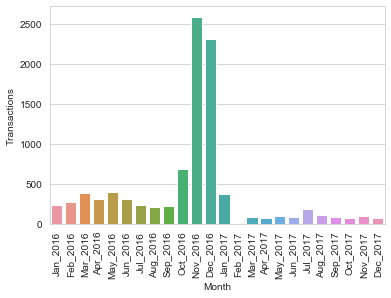

In [22]:
# plot bargraph
sns.set_style(style="whitegrid")
s = sns.barplot(x='Month',y='Transactions', data=merged)
s.set_xticklabels(merged['Month'],rotation=90)

### In 2016, business seemed to be pretty good and peaked at the end of the year. However, starting Feb 2017, number of transactions plunged to zero. There were some transactions in the subsequent months but never recovered to the level in 2016.